In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Rescaling, Resizing, RandomFlip, RandomRotation,RandomTranslation,CenterCrop,RandomContrast,ZeroPadding2D


In [3]:
import cv2

# Update the dataset_folder to match your Google Drive folder structure
dataset_folder = '/content/drive/MyDrive/ClassData'


#load,resize and preprocess images
def load_data(path, target_size=(224, 224)):
    labels = []
    preprocessed_images = []
    for folder in os.listdir(path):
        for file in os.listdir(os.path.join(path, folder)):
            # Load the data and labels
            img_path = os.path.join(path, folder, file)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            resized_image = cv2.resize(img, (224, 224))
            preprocessed_image = preprocess_input(resized_image)
            preprocessed_images.append(preprocessed_image)          
            # Resize the image
            resized_img = cv2.resize(img, target_size)   
            labels.append(folder)

    labels = np.array(labels)
    preprocessed_images = np.array(preprocessed_images)
    return preprocessed_images, labels

#load train, test and validation data
train_data, train_labels = load_data(os.path.join(dataset_folder,"train"))
valid_data, valid_labels = load_data(os.path.join(dataset_folder,"valid"))
test_data, test_labels = load_data(os.path.join(dataset_folder,"test"))

In [4]:
#Modify No justification to Written  (combining two classes for SVM)
train_labels_v1 = np.where(train_labels == 'cls_no_jstfn','cls_wrtn',train_labels)
valid_labels_v1 = np.where(valid_labels == 'cls_no_jstfn','cls_wrtn',valid_labels)

In [5]:
# Load pre-trained EfficientNetB0 without the top classification layer
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

# Extract features from the images
train_features = efficientnet.predict(train_data)

#valid data features
valid_features = efficientnet.predict(valid_data)


#test data features
test_features = efficientnet.predict(test_data)

24/24 [==============================] - 2s 79ms/step


In [6]:
#Extracting intermediate feature maps
# Select a specific layer by its name
layer_name = 'block3a_expand_activation'
intermediate_layer_model = Model(inputs=efficientnet.input, outputs=efficientnet.get_layer(layer_name).output)

# Get the feature maps for an image in your dataset
image_index = 776  # Choose an index of the image you want to visualize
intermediate_output = intermediate_layer_model.predict(np.expand_dims(train_data[image_index], axis=0))


1/1 [==============================] - 1s 501ms/step


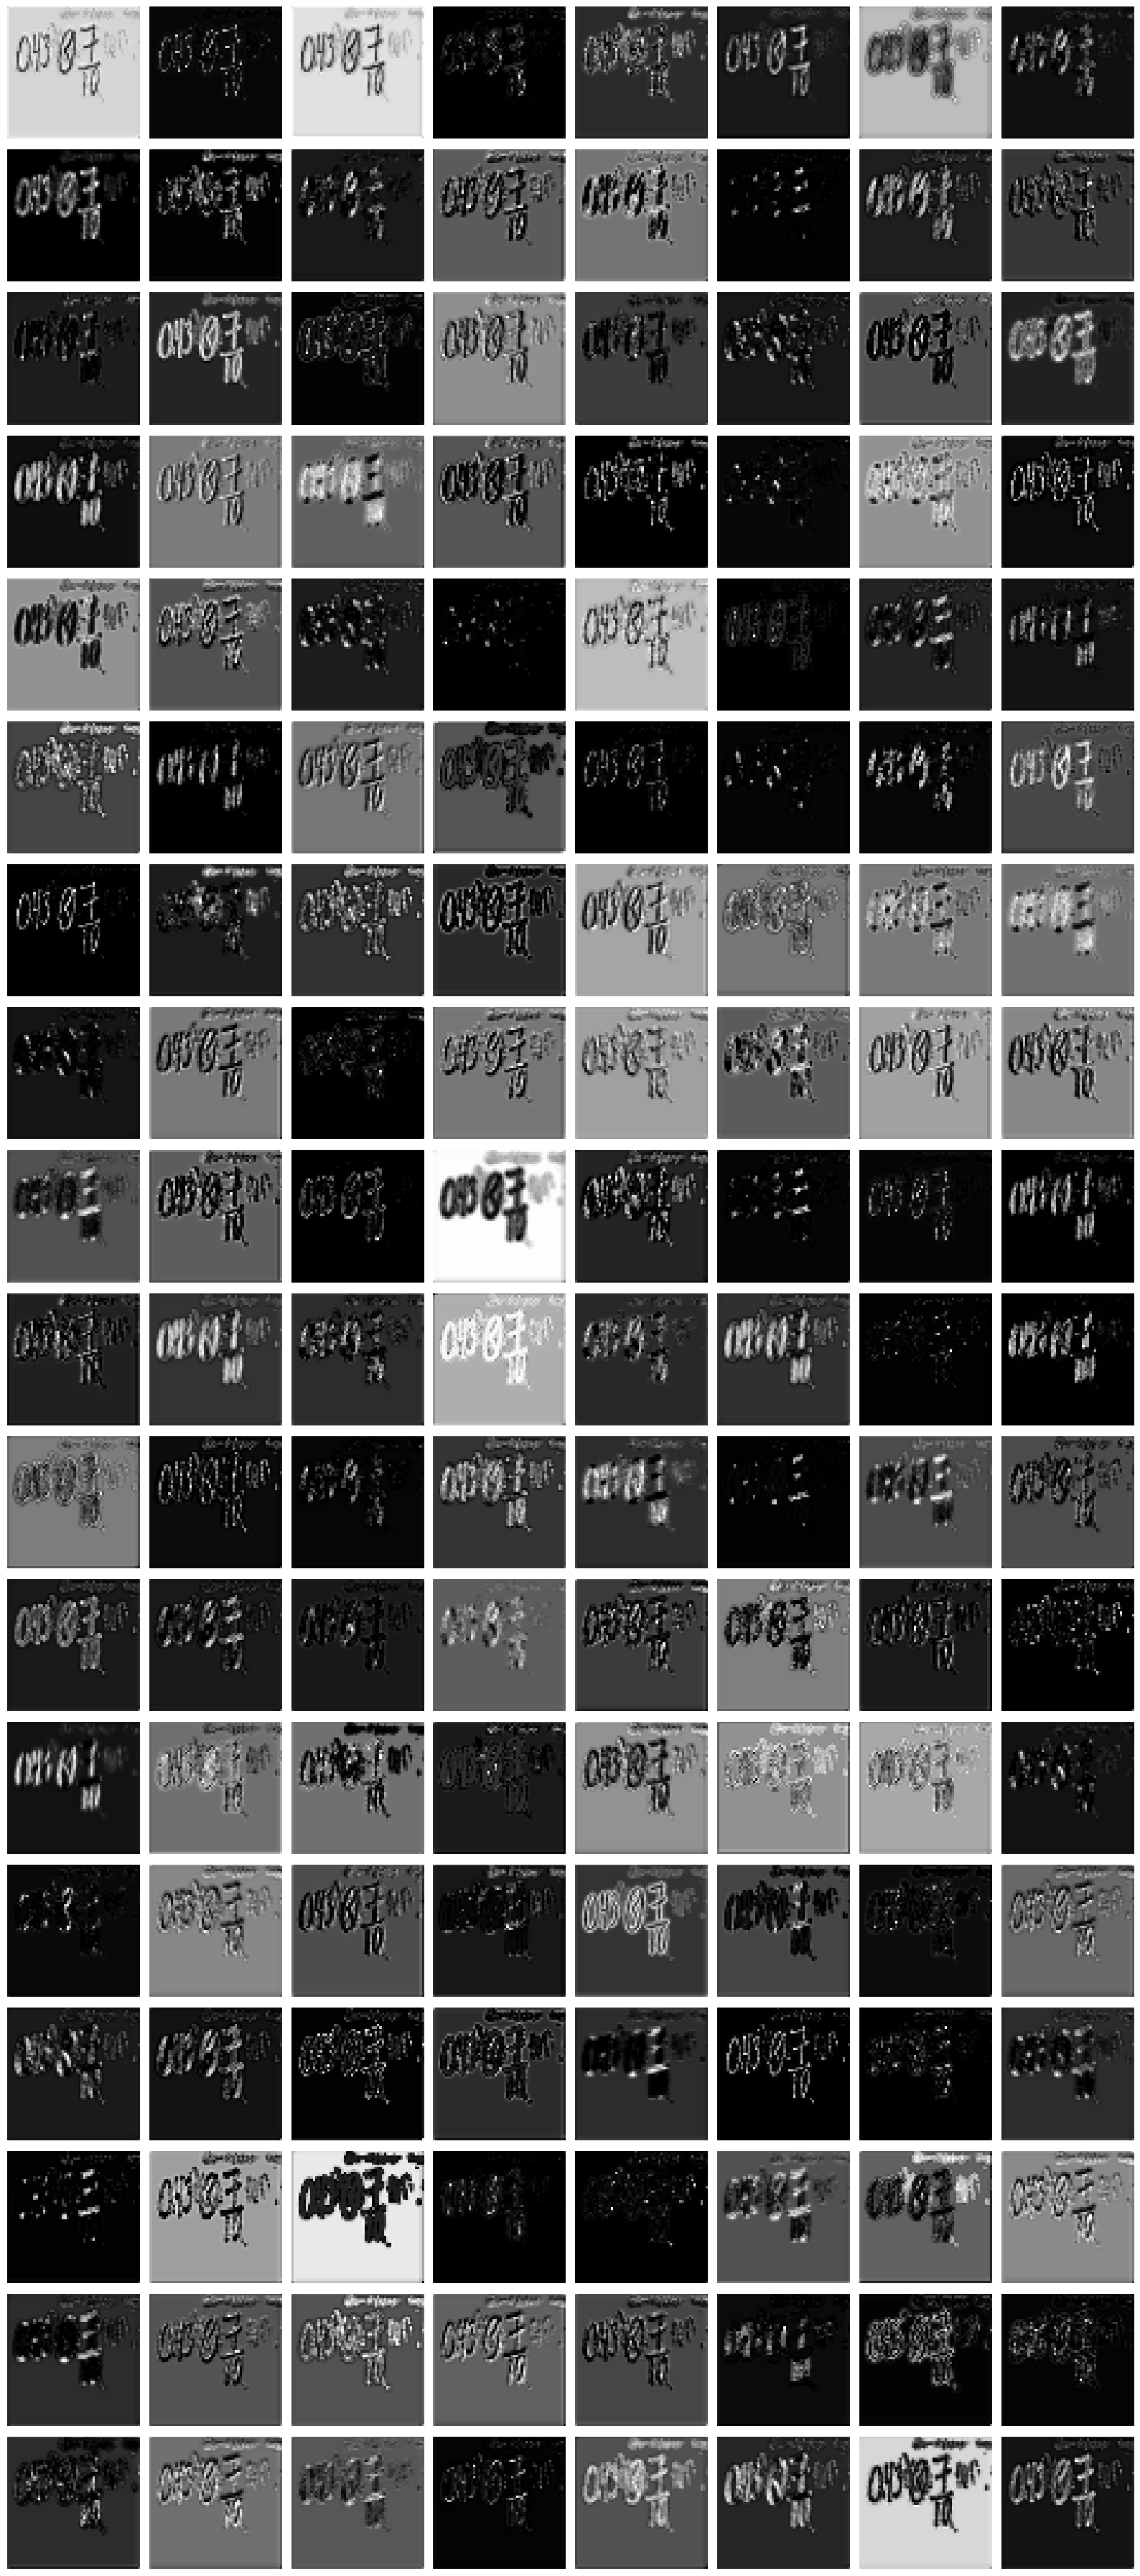

In [7]:
# Display the feature maps
num_feature_maps = intermediate_output.shape[-1]
num_columns = 8
num_rows = num_feature_maps // num_columns + (1 if num_feature_maps % num_columns > 0 else 0)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, num_rows * 2))
axes = axes.ravel()

for i in range(num_feature_maps):
    axes[i].imshow(intermediate_output[0, :, :, i], cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


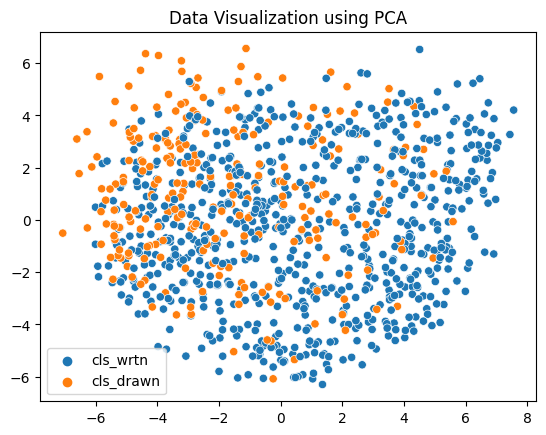

In [ ]:
# Visualize the data
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(train_features)
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=train_labels_v1)
plt.title("Data Visualization using PCA")
plt.show()

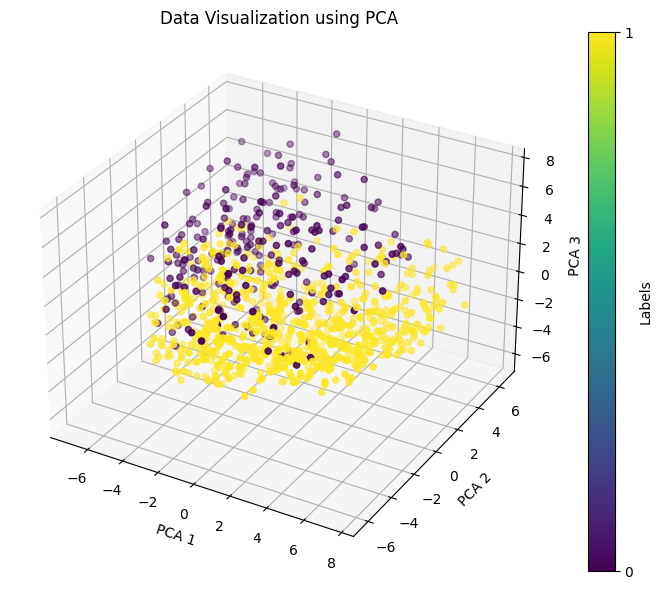

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA


#3d space
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(train_features)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
train_labels_v1_mod = np.where(train_labels == 'cls_drawn',0,1)
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=train_labels_v1_mod)

# Add axis labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title("Data Visualization using PCA")

# Add a colorbar legend
legend = fig.colorbar(scatter, ticks=range(len(np.unique(train_labels))))
legend.set_label('Labels')


plt.show()


In [13]:
# Create a support vector classifier
clf = SVC(kernel='poly',degree=2,probability=True)

# Fit the classifier to the training data
clf.fit(train_features, train_labels_v1)

# Make predictions
y_pred = clf.predict(valid_features)

y_pred_prob = clf.predict_proba(valid_features)

#train predictions
train_pred = clf.predict(train_features)

#
print('Training Report',classification_report(train_labels_v1, train_pred))

# Print the classification report
print('Validation Report',classification_report(valid_labels_v1, y_pred))

Training Report               precision    recall  f1-score   support

   cls_drawn       1.00      0.85      0.92       258
    cls_wrtn       0.95      1.00      0.97       745

    accuracy                           0.96      1003
   macro avg       0.97      0.92      0.95      1003
weighted avg       0.96      0.96      0.96      1003

Validation Report               precision    recall  f1-score   support

   cls_drawn       0.93      0.70      0.80        40
    cls_wrtn       0.96      0.99      0.97       265

    accuracy                           0.95       305
   macro avg       0.94      0.85      0.89       305
weighted avg       0.95      0.95      0.95       305



In [14]:
from sklearn.metrics import classification_report,roc_auc_score

print("Validation Accuracy:", accuracy_score(valid_labels_v1, y_pred))

valid_labels_v1_mod = np.where(valid_labels_v1=='cls_wrtn',0,1)
y_pred = np.where(y_pred=='cls_wrtn',0,1)

auc_roc = roc_auc_score(valid_labels_v1_mod, y_pred)
print("ROC-AUC score:", auc_roc)

Validation Accuracy: 0.9540983606557377
ROC-AUC score: 0.8462264150943396


In [15]:
# Make predictions for first SVM Classifier
y_pred = clf.predict(test_features)

test_labels_mod = np.where(test_labels == 'cls_no_jstfn','cls_wrtn',test_labels)
# Print the classification report
print('Test Report',classification_report(test_labels_mod, y_pred))

print("Test Accuracy:", accuracy_score(test_labels_mod, y_pred))


test_labels_v1_mod = np.where(test_labels_mod=='cls_wrtn',0,1)
y_pred = np.where(y_pred=='cls_wrtn',0,1)

auc_roc = roc_auc_score(test_labels_v1_mod, y_pred)
print("ROC-AUC score:", auc_roc)

Test Report               precision    recall  f1-score   support

   cls_drawn       0.93      0.79      0.85       100
    cls_wrtn       0.97      0.99      0.98       666

    accuracy                           0.96       766
   macro avg       0.95      0.89      0.92       766
weighted avg       0.96      0.96      0.96       766

Test Accuracy: 0.9647519582245431
ROC-AUC score: 0.8904954954954956


In [16]:
#filter data for second classifier
train_mask = train_labels != 'cls_drawn'

train_data_v2 = train_data[train_mask]
train_labels_v2 = train_labels[train_mask]

valid_mask = valid_labels != 'cls_drawn'

valid_data_v2 = valid_data[valid_mask]
valid_labels_v2 = valid_labels[valid_mask]

In [17]:
# Extract features from the images
train_features_v2 = efficientnet.predict(train_data_v2)

valid_features_v2 = efficientnet.predict(valid_data_v2)


9/9 [==============================] - 0s 48ms/step


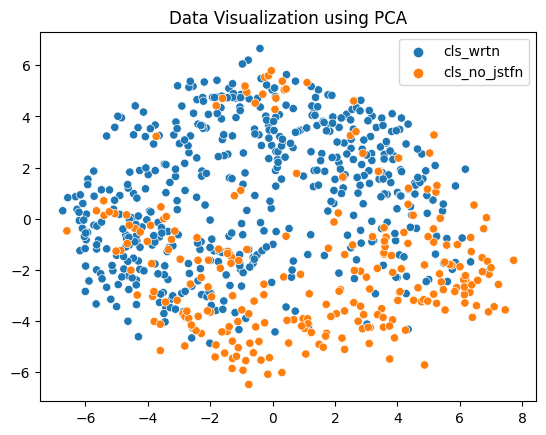

In [18]:
# Visualize the data
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(train_features_v2)
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=train_labels_v2)
plt.title("Data Visualization using PCA")
plt.show()

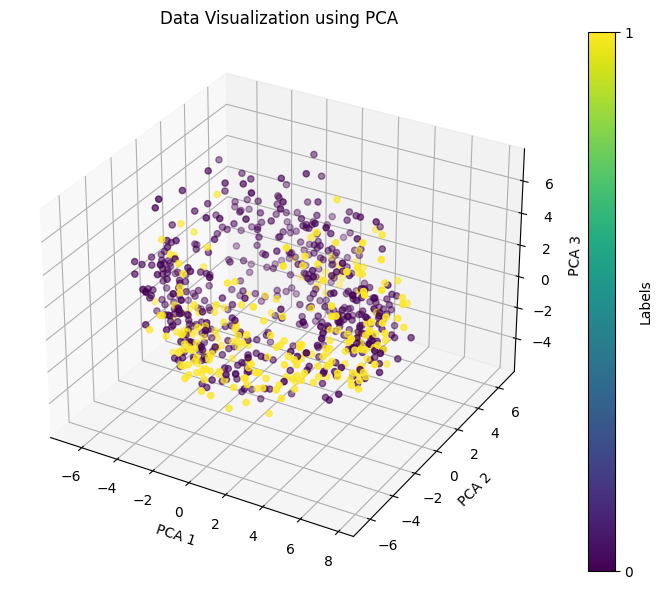

In [21]:
#3d space
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(train_features_v2)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
train_labels_v2_mod = np.where(train_labels_v2 == 'cls_wrtn',0,1)
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=train_labels_v2_mod)

# Add axis labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title("Data Visualization using PCA")

# Add a colorbar legend
legend = fig.colorbar(scatter, ticks=range(len(np.unique(train_labels_v2_mod))))
legend.set_label('Labels')


plt.show()


In [ ]:
# Create a support vector classifier
clf2 = SVC(kernel='rbf',probability=True)

# Fit the classifier to the training data
clf2.fit(train_features_v2, train_labels_v2)

# Make predictions
y_pred_v2 = clf2.predict(valid_features_v2)

#train predictions
train_pred_v2 = clf2.predict(train_features_v2)

#
print('Training Report',classification_report(train_labels_v2, train_pred_v2))

# Print the classification report
print('Validation Report',classification_report(valid_labels_v2, y_pred_v2))

Training Report               precision    recall  f1-score   support

cls_no_jstfn       0.94      0.84      0.89       245
    cls_wrtn       0.93      0.98      0.95       500

    accuracy                           0.93       745
   macro avg       0.94      0.91      0.92       745
weighted avg       0.93      0.93      0.93       745

Validation Report               precision    recall  f1-score   support

cls_no_jstfn       0.72      0.70      0.71        37
    cls_wrtn       0.95      0.96      0.95       228

    accuracy                           0.92       265
   macro avg       0.84      0.83      0.83       265
weighted avg       0.92      0.92      0.92       265



In [ ]:
#final predictions

#first SVM Classifeir
first_pred = clf.predict(test_features)
first_pred_v1 = first_pred.copy()

first_pred_prob = clf.predict_proba(test_features)

In [ ]:
#filtering out class_wrtn
second_clf_indices = np.where(first_pred=='cls_wrtn')[0]

# Extract the subset of test_data for further classification
test_features_v2 = test_features[second_clf_indices]

# Use the second classifier to predict on the test_data_subset
second_pred = clf2.predict(test_features_v2)
second_pred_proba = clf2.predict(test_features_v2)

# Update the first set of predictions with the second set of predictions
first_pred[second_clf_indices] = second_pred

# Compute the overall accuracy
overall_accuracy = accuracy_score(test_labels, first_pred)
print("Overall accuracy:", overall_accuracy)

Overall accuracy: 0.9112271540469974


In [ ]:
print('Test Classification:',classification_report(test_labels, first_pred))


Test Classification:               precision    recall  f1-score   support

   cls_drawn       0.93      0.79      0.85       100
cls_no_jstfn       0.79      0.75      0.77        95
    cls_wrtn       0.93      0.96      0.94       571

    accuracy                           0.91       766
   macro avg       0.88      0.83      0.85       766
weighted avg       0.91      0.91      0.91       766



In [ ]:
#saving model weights
import joblib

# Save the trained SVM model

#classifier 1
joblib.dump(clf, '/content/drive/MyDrive/ModelWeights/svm_model_1.pkl')

#classifier 2
joblib.dump(clf2, '/content/drive/MyDrive/ModelWeights/svm_model_2.pkl')


['/content/drive/MyDrive/svm_model_2.pkl']